# Network/Graph Representation Learning tutorial

## Preprocess

In [1]:
import numpy as np
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt

import json

## DGL
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from progressbar import progressbar

Using backend: pytorch


In [2]:
## Load manually created DC Metro Data
df = pd.read_csv('../data/raw/dc_metro.csv', sep=',')
df.head()

,Start,Stop,Line,Color
0,Shady Grove,Rockville,1,red
1,Rockville,Twinbrook,1,red
2,Twinbrook,White Flint,1,red
3,White Flint,Grosvenor-Strathmore,1,red
4,Grosvenor-Strathmore,Medical Center,1,red


In [3]:
## Load station geographic coordinates
df_gis = pd.read_csv('../data/raw/dc_metro_gis.csv')
df_gis.head()

,dc_metro_name,mean_lon,mean_lat
0,Addison Rd,-76.895818,38.886732
1,Anacostia,-76.995193,38.862145
2,Archives,-77.022550,38.893951
3,Arlington Cemetery,-77.063675,38.884388
4,Ballston-MU,-77.111312,38.881915


In [4]:
## Rescale coordinates to [-1, 1]
df_gis['rescale_lon'] = np.interp(df_gis['mean_lon'], (df_gis['mean_lon'].min(), df_gis['mean_lon'].max()), (-1, 1))
df_gis['rescale_lat'] = np.interp(df_gis['mean_lat'], (df_gis['mean_lat'].min(), df_gis['mean_lat'].max()), (-1, 1))

In [5]:
## Convert DC Metro data to dictionary of station-id/id-station
stations = pd.unique(df[['Start', 'Stop']].values.flatten())
stations = sorted(stations)
station2id = {s:i for i, s in enumerate(stations)}
id2station = dict(enumerate(stations))

In [61]:
## Create dictionary of id-rescaled geographic coordinate 
id_pos = {}

for key in station2id:
    id_pos[station2id[key]] = [df_gis.loc[df_gis['dc_metro_name'] == key]['rescale_lon'],
                               df_gis.loc[df_gis['dc_metro_name'] == key]['rescale_lat']]

In [7]:
## Create multigraph object
G = nx.MultiGraph()

In [8]:
## Add stations as nodes to graph object
for station_name, id in station2id.items():
    G.add_node(id, name=station_name)

In [9]:
## Add lines as edges to graph object
for i, series in df.iterrows():
    u = station2id[series['Start']]
    v = station2id[series['Stop']]
    line = series['Line']
    color = series['Color']
    G.add_edge(u, v, line=line, color=color)

In [10]:
## Assign graph data to JSON
dc_metro_graph = nx.node_link_data(G)

In [11]:
## Add geographic coordinates to JSON
for i in range(0, len(dc_metro_graph['nodes'])):
    dc_metro_graph['nodes'][i]['cx'] = id_pos[i][0].squeeze()
    dc_metro_graph['nodes'][i]['cy'] = id_pos[i][1].squeeze()

In [13]:
## Export JSON data for D3 visualization
with open('../data/processed/dc_metro_graph.json', 'w') as f:
    json.dump(dc_metro_graph, f)

In [46]:
station2id

{'Addison Rd': 0,
 'Anacostia': 1,
 'Archives': 2,
 'Arlington Cemetery': 3,
 'Ballston-MU': 4,
 'Benning Rd': 5,
 'Bethesda': 6,
 'Braddock Rd': 7,
 'Branch Ave': 8,
 'Brookland-CUA': 9,
 'Capitol Heights': 10,
 'Capitol South': 11,
 'Cheverly': 12,
 'Clarendon': 13,
 'College Park-U of Md': 14,
 'Columbia Heights': 15,
 'Congress Heights': 16,
 'Court House': 17,
 'Crystal City': 18,
 'Deanwood': 19,
 'Dunn Loring': 20,
 'Dupont Circle': 21,
 'East Falls Church': 22,
 'Eastern Market': 23,
 'Eisenhower Ave': 24,
 'Farragut North': 25,
 'Farragut West': 26,
 'Federal Center SW': 27,
 'Federal Triangle': 28,
 'Foggy Bottom-GWU': 29,
 'Forest Glen': 30,
 'Fort Totten': 31,
 'Franconia-Springfield': 32,
 'Friendship Heights': 33,
 'Gallery Place': 34,
 'Georgia Ave-Petworth': 35,
 'Glenmont': 36,
 'Greenbelt': 37,
 'Greensboro': 38,
 'Grosvenor-Strathmore': 39,
 'Huntington': 40,
 'Judiciary Square': 41,
 'King St-Old Town': 42,
 'LEnfant Plaza': 43,
 'Landover': 44,
 'Largo Town Center'

In [68]:
id2station

{0: 'Addison Rd',
 1: 'Anacostia',
 2: 'Archives',
 3: 'Arlington Cemetery',
 4: 'Ballston-MU',
 5: 'Benning Rd',
 6: 'Bethesda',
 7: 'Braddock Rd',
 8: 'Branch Ave',
 9: 'Brookland-CUA',
 10: 'Capitol Heights',
 11: 'Capitol South',
 12: 'Cheverly',
 13: 'Clarendon',
 14: 'College Park-U of Md',
 15: 'Columbia Heights',
 16: 'Congress Heights',
 17: 'Court House',
 18: 'Crystal City',
 19: 'Deanwood',
 20: 'Dunn Loring',
 21: 'Dupont Circle',
 22: 'East Falls Church',
 23: 'Eastern Market',
 24: 'Eisenhower Ave',
 25: 'Farragut North',
 26: 'Farragut West',
 27: 'Federal Center SW',
 28: 'Federal Triangle',
 29: 'Foggy Bottom-GWU',
 30: 'Forest Glen',
 31: 'Fort Totten',
 32: 'Franconia-Springfield',
 33: 'Friendship Heights',
 34: 'Gallery Place',
 35: 'Georgia Ave-Petworth',
 36: 'Glenmont',
 37: 'Greenbelt',
 38: 'Greensboro',
 39: 'Grosvenor-Strathmore',
 40: 'Huntington',
 41: 'Judiciary Square',
 42: 'King St-Old Town',
 43: 'LEnfant Plaza',
 44: 'Landover',
 45: 'Largo Town Cen

In [63]:
custom_pos = id_pos.copy()

In [66]:
custom_pos.update({
    # Blue Line: Benning -Largo
    5:  [0.70, -0.30],
    10: [0.75, -0.30],
    51: [0.85, -0.30],
    45: [0.90, -0.30],
    0:  [0.80, -0.30],
    # Orange Line: Minnesota Ave - New Carrolton
    50: [0.66, -0.25],
    19: [0.71, -0.20],
    12: [0.76, -0.15],
    44: [0.81, -0.10],
    55: [0.86, -0.05] ,
    # Blue/Silver/Orange: Federal Center - Stadium
    71: [0.60, -0.30]
    
})

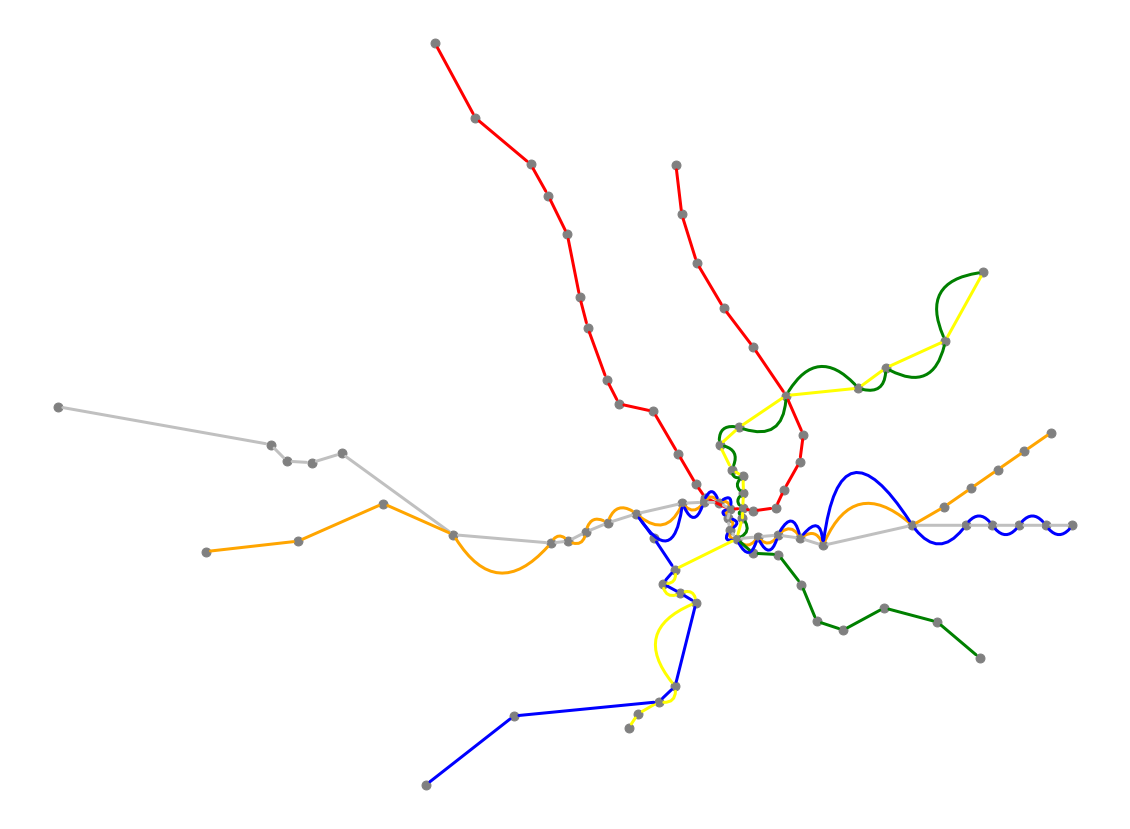

In [67]:
plt.figure(figsize=(20,15))

nx.draw_networkx_nodes(G, custom_pos, node_color='grey', node_size=80)

ax = plt.gca()

for e in G.edges:
    ax.annotate(
        "",
        xy=custom_pos[e[0]], 
        xycoords='data',
        xytext=custom_pos[e[1]], 
        textcoords='data',
        arrowprops=dict(
            arrowstyle="-", 
            color=nx.get_edge_attributes(G, 'color')[e],
            linewidth = 3,
            shrinkA = 5, 
            shrinkB = 5,
            patchA = None, 
            patchB = None,
            connectionstyle="arc3,rad=rrr".replace('rrr',str(0.7*e[2])),
        ),
    )

plt.axis('off')
plt.show()


## Semi-supervised Learning

### Graph Convolutional Network

In [18]:
dgl.__version__

'0.6.1'

In [19]:
def to_dgl(G):
    g = dgl.DGLGraph()
    g.add_nodes(len(G))
    edge_list = [(u,v) for u,v in nx.edges(G)]
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    g.add_edges(dst, src)
    return g



# You can revert this convertion with the `to_networkx` function.
# G = g.to_networkx().to_undirected()

In [20]:
g = to_dgl(G)

c:\users\vince\appdata\local\programs\python\python39\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [21]:
onehot_features = torch.eye(len(G))
g.ndata['feat'] = onehot_features

In [22]:
# Define the message & reduce function
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.update_all(gcn_message, gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)
    
# Define a 2-layer GCN model
class BasicGCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(BasicGCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h

Now we consider correct labels corresponding to nodes, a.k.a. **supervisers** or **labels**, which 

In [23]:
unique_colors = pd.unique(list(nx.get_edge_attributes(G, 'color').values()))

A representative node for each color as follows:

- red: `36, 65`
- silver: `46, 88`
- orange: `55, 81`
- blue: `3, 32`
- yellow: `24, 40`
- green: `8, 83`


In [24]:
unique_colors

array(['silver', 'blue', 'green', 'yellow', 'orange', 'red'], dtype=object)

In [25]:
# The first layer transforms input features of size of #nodes to a hidden size of 10.
# The second layer transforms the hidden layer and produces output features of
# size , corresponding to the six colors of the representative nodes.
random.seed(2021)

net = BasicGCN(g.number_of_nodes(), 10, 6)

inputs = torch.eye(g.number_of_nodes())
labeled_nodes = torch.tensor([36, 65, 
                              46, 88, 
                              55, 81, 
                              3, 32, 
                              24, 40, 
                              8, 83]) 
labels = torch.tensor([5,5,
                       0,0,
                       4,4,
                       1,1,
                       3,3,
                       2,2]) 

# Options for learning
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
n_epochs = 100

all_logits = []
losses = []

for epoch in progressbar(range(n_epochs)):
    logits = net(g, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


In [26]:
## Assign final prediction 
predictions = [unique_colors[x] for x in all_logits[-1].argmax(axis=-1)]

In [27]:
## Obtain list of predictions from first 40 epochs
node_predictions = {}

for key in id2station:
    node_predictions[key] = [
        [unique_colors[x] for x in all_logits[0].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[2].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[4].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[6].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[8].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[10].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[12].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[14].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[16].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[18].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[20].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[22].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[24].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[26].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[28].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[30].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[32].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[34].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[36].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[38].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[40].argmax(axis=-1)][key],
        [unique_colors[x] for x in all_logits[-1].argmax(axis=-1)][key]
    ]

In [28]:
## Add predictions to graph JSON
for i in range(0, len(dc_metro_graph['nodes'])):
    dc_metro_graph['nodes'][i]['predictions'] = node_predictions[i]

In [30]:
## Export JSON data for D3 visualization
with open('../data/processed/dc_metro_graph_predictions.json', 'w') as f:
    json.dump(dc_metro_graph, f)

In [31]:
def plot_loss(losses, n_epochs, **kwargs):
    fig, ax = plt.subplots(**kwargs)
    ax.plot(range(n_epochs), losses)
    fig.set_facecolor('white')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title("")
    plt.show()

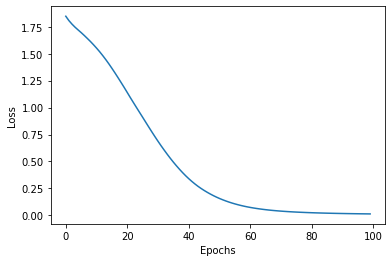

In [32]:
plot_loss(losses, n_epochs)

In [33]:
plt.savefig('../_graphics/plot_loss.png')

<Figure size 432x288 with 0 Axes>

In [47]:
## Export losses data for visualization in D3.js
df_losses = pd.DataFrame(
    losses,
    columns = ['losses'])\
    .reset_index()\
    .rename(columns={'index':'n_epochs'})

df_losses.to_csv('../data/processed/losses.csv')

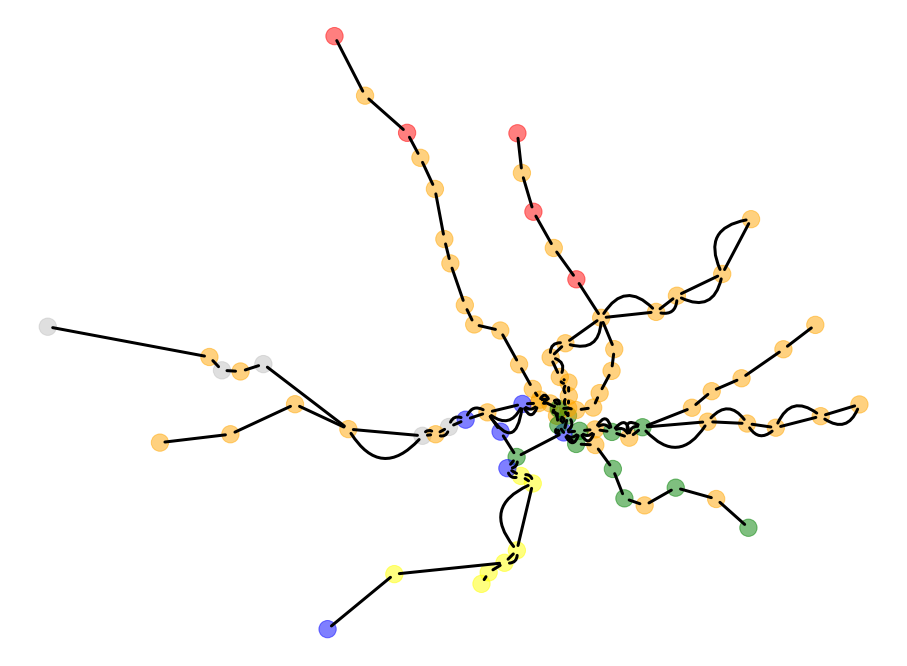

In [35]:
def plot_predictions(id_pos, predictions):
    plt.figure(figsize=(16,12))

    nx.draw_networkx_nodes(G, id_pos, node_color=predictions, alpha=0.5, node_size=300)

    ax = plt.gca()
    
    for e in G.edges:
        ax.annotate(
            "",
            xy=id_pos[e[0]], 
            xycoords='data',
            xytext=id_pos[e[1]], 
            textcoords='data',
            arrowprops=dict(
                arrowstyle="-", 
                color='black',
                linewidth = 3,
                shrinkA = 5, 
                shrinkB = 5,
                patchA = None, 
                patchB = None,
                connectionstyle="arc3,rad=rrr".replace('rrr',str(0.7*e[2])),
            ),
        )

    plt.axis("off")
    plt.show()

plot_predictions(id_pos, predictions)

## Define a more sophisticated GCN model.

Following code has depreciated

In [50]:
import torch
import torch.nn as nn
from dgl.nn.pytorch import GraphConv

class GCN(nn.Module):
    def __init__(self,
                 g,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_layers,
                 activation,
                 dropout):
        super(GCN, self).__init__()
        self.g = g
        self.dropout = nn.Dropout(p=dropout)
        
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(GraphConv(in_feats, n_hidden, activation=activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(GraphConv(n_hidden, n_hidden, activation=activation))
        # output layer
        self.layers.append(GraphConv(n_hidden, n_classes))

    def forward(self, features):
        h = features
        for i, layer in enumerate(self.layers):
            if i != 0:
                h = self.dropout(h)
            h = layer(self.g, h)
        # output logits
        return h

In [51]:
# cuda option
cuda = False

# normalization term
degs = g.in_degrees().float()
norm = torch.pow(degs, -0.5)
norm[torch.isinf(norm)] = 0
if cuda:
    norm = norm.cuda()
g.ndata['norm'] = norm.unsqueeze(1)

# hyper parameters
n_epochs = 100
n_layers = 3
n_hidden = 16
dropout = 0.3
weight_decay = 5e-4
lr=0.01

# feature and target class
features  = torch.eye(len(g.nodes))
in_feats = features.shape[1]
n_classes = len(unique_colors)

# supervise data

labeled_nodes = torch.tensor([
    36, 65, 
    46, 88, 
    55, 81, 
    3, 32, 
    24, 40, 
    8, 83])

labels = torch.tensor([
    5,5,
    0,0,
    4,4,
    1,1,
    3,3,
    2,2]) 

model = GCN(g,
            in_feats,
            n_hidden,
            n_classes,
            n_layers,
            F.relu,
            dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

all_logits = []
losses = []

n_epochs = 200
for epoch in progressbar(range(n_epochs)):
    model.train()
    logits = model(features)
#     all_logits.append(logits.detach())

    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

TypeError: object of type 'HeteroNodeView' has no len()

In [ ]:
plot_loss(losses, n_epochs)

In [ ]:
predictions = [unique_colors[x] for x in logits.argmax(axis=-1)]
plot_predictions(pos, predictions)

More advanced GCN

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
from dgl.nn.pytorch import SumPooling, MaxPooling

# https://github.com/pengchenghu428/GraphTools/blob/master/experiment/pytorch/gcn.py
class AdvancedGCN(nn.Module):
    def __init__(self,
                 g,
                 in_feats,
                 n_output=2,
                 n_hidden_gcn=[256, 256, 256],
                 n_hidden_mlp=[32],
                 n_dense_hidden=128,
                 activation=F.leaky_relu,
                 dropout=0.2):
        super(AdvancedGCN, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.activation = activation
        self.n_dense_hidden = n_dense_hidden
        self.n_hidden_gcn = n_hidden_gcn
        self.g = g
        
        # GCN layer
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(GraphConv(in_feats, n_hidden_gcn[0], activation=activation))
        for i in range(len(n_hidden_gcn)-1):
            self.gcn_layers.append(GraphConv(n_hidden_gcn[i], n_hidden_gcn[i+1], activation=activation))
        
        # MLP layer
        n_hidden_mlp.append(n_output)
        self.mlp_layers = nn.ModuleList()
        self.mlp_layers.append(nn.Linear(n_hidden_gcn[-1], n_hidden_mlp[0]))
        for i in range(len(n_hidden_mlp)-1):
            self.mlp_layers.append(nn.Linear(n_hidden_mlp[i], n_hidden_mlp[i+1]))

    def forward(self, features):
        self.h = []
        h = features
        
        # GCN
        for i, gcn_layer in enumerate(self.gcn_layers):
            if i != 0:
                h = self.dropout(h)
            h = gcn_layer(self.g, h)
            self.h.append(h)
            
        # MLP
        for i, mlp_layer in enumerate(self.mlp_layers):
            if i != 0:
                h = self.dropout(h)
            h = mlp_layer(h)
            h = F.relu(h)
            self.h.append(h)
        
        return h
    
    def _get_flatten_size(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = AdvancedGCN(g,
                    in_feats,
                    n_hidden_gcn=[16, 16],
                    n_hidden_mlp=[8],
                    n_output=n_classes,
                    dropout=0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

all_logits = []
losses = []

n_epochs = 100
for epoch in progressbar(range(n_epochs)):
    model.train()
    logits = model(features)
    
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

NameError: name 'in_feats' is not defined

In [ ]:
plot_loss(losses, n_epochs)

In [ ]:
predictions = [unique_colors[x] for x in logits.argmax(axis=-1)]
plot_predictions(pos, predictions)

In [ ]:
for h in model.h:
    print(h.shape)

In [ ]:
for i, h in enumerate(model.h):
    if h.shape[1] == 2:
        embed_pos = {i: [node[0], node[1]] for i, node in enumerate(h.detach())}
        plot_predictions(embed_pos, predictions)
        break

In [ ]:
from sklearn.manifold import TSNE

embedded = TSNE(n_components=2).fit_transform(model.h[-1].detach())
embed_pos = {i: [node[0], node[1]] for i, node in enumerate(embedded)}
plot_predictions(embed_pos, predictions)